In [31]:

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import tqdm
from typing import Optional

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split


In [32]:
DATA_DIR = Path("Z:\\Dropbox\\www\\steelfeet.ru\\_hack\\2021-22\global-ai")
#DATA_DIR = pathlib.Path("C:\\0")
DATA_FILE = "train.csv"
TEST_FILE = "test.csv"
#group_by столбцы


# Загрузка данных

In [33]:
df = pd.read_csv(DATA_DIR.joinpath(DATA_FILE), usecols=["Smiles", "Active"])
df["Smiles"]



0                                 COc1ccc2[nH]cc(CCN)c2c1
1                         CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
2       O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...
3       Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...
4                 Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1
                              ...                        
5552    O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...
5553                     Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1
5554                                      Oc1cccc2cccnc12
5555    OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...
5556                      CCCCNc1ccc(C(=O)OCCN(C)C)cc1.Cl
Name: Smiles, Length: 5557, dtype: object

# Класс для предобработки датасета

In [34]:
from rdkit import Chem
from multiprocessing import Pool

class StandardizeDatasets:
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        mol = Chem.MolFromSmiles(smi)
        mol = Chem.MolToSmiles(mol)
        return mol
        "crete typical standardization of one smiles"

    def standardize(self, df, out_path: Path):
        with Pool(10) as pool:
          df['standardize_smiles'] = list(
                      tqdm(pool.imap(self.standardize_smiles, df.smiles), total=df.shape[0])
                  )
        df.to_csv(out_path, index=False)
        return df
        "apply standardization to all smiles"

class StandardizeTautomers(StandardizeDatasets):
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        Canonicalizer = Chem.TautomerCanonicalizer()
        mol = Chem.MolFromSmiles(smi)
        standorized = Canonicalizer.canonicalize(mol)
        return Chem.MolToSmiles(standorized)

In [35]:
def get_atom_features(mol):
   atomic_number = []
   num_hs = []
   degrees = []
   charges = []
   tags = []
   hybridizations = []
   aromatic = []
   mass = []
 
   for atom in mol.GetAtoms():
       atomic_number.append(atom.GetAtomicNum()) # atomic number
       num_hs.append(atom.GetTotalNumHs(includeNeighbors=True)) # number of H in atom
       degrees.append(atom.GetTotalDegree()) # total Degree of atom
       charges.append(atom.GetFormalCharge()) # Charge of atom
       tags.append(int(atom.GetChiralTag())) # chiral tag
       hybridizations.append(int(atom.GetHybridization())) # hybridization of atom
       if atom.GetIsAromatic(): # Is aromatic of not
           aromatic.append(1)
       else:
           aromatic.append(0)
       mass.append(atom.GetMass() * 0.01) # mass
              
   return torch.tensor([atomic_number, num_hs, degrees, charges, tags, hybridizations, aromatic, mass]).t()
 
def get_edge_index(mol):
   row, col = [], []
  
   for bond in mol.GetBonds():
       start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
       row += [start, end]
       col += [end, start]
      
   return torch.tensor([row, col], dtype=torch.long)

In [36]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
   def __init__(self, in_channels, out_channels):
       super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
       self.lin = torch.nn.Linear(in_channels, out_channels)
 
   def forward(self, x, edge_index):
       # x has shape [N, in_channels]
       # edge_index has shape [2, E]
 
       # Step 1: Add self-loops to the adjacency matrix.
       edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
 
       # Step 2: Linearly transform node feature matrix.
       x = self.lin(x)
 
       # Step 3: Compute normalization.
       row, col = edge_index
       deg = degree(col, x.size(0), dtype=x.dtype)
       deg_inv_sqrt = deg.pow(-0.5)
       norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
 
       # Step 4-5: Start propagating messages.
       return self.propagate(edge_index, x=x, norm=norm)
 
   def message(self, x_j, norm):
       # x_j has shape [E, out_channels]
 
       # Step 4: Normalize node features.
       return norm.view(-1, 1) * x_j

In [37]:
class NeuralFP(nn.Module):
   def __init__(self, atom_features=52, fp_size=50):
       super(NeuralFP, self).__init__()
      
       self.atom_features = atom_features
       self.fp_size = fp_size
 
      
       self.loop1 =  GCNConv(atom_features, fp_size)
 
       self.loops = nn.ModuleList([self.loop1])
      
   def forward(self, data):
       fingerprint = torch.zeros((data.batch.shape[0], self.fp_size), dtype=torch.float).to(device)
      
       out = data.x
       for idx, loop in enumerate(self.loops):
    
           updated_fingerprint = loop(out, data.edge_index)
           fingerprint += updated_fingerprint
 
       return scatter_add(fingerprint, data.batch, dim=0)

In [38]:
import torch.nn.functional as F
 
class MLP_Regressor(nn.Module):
   def __init__(self, neural_fp, atom_features=2, fp_size=50, hidden_size=100):
       super(MLP_Regressor, self).__init__()
 
 
       self.neural_fp = neural_fp
       self.lin1 =  nn.Linear(fp_size , hidden_size)
       self.leakyrelu = nn.LeakyReLU(0.2)
       self.lin2 =  nn.Linear(hidden_size, 1)
       self.dropout =  nn.Dropout(0.2)
  
   def forward(self, batch):
 
       fp = self.neural_fp(batch)
       hidden =  self.dropout(self.lin1(fp))
       out =  self.leakyrelu(self.lin2(hidden))
       return out

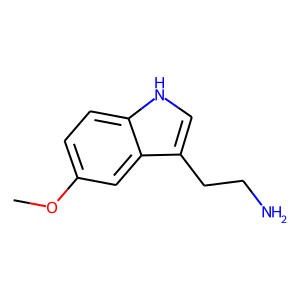

In [42]:
import rdkit.Chem.Draw
mol = Chem.MolFromSmiles('COc1ccc2[nH]cc(CCN)c2c1')
rdkit.Chem.Draw.MolToImage(mol)

